# This nb is used to generate the calibration files for the different ABCs' heaters

## Imports

In [1]:
import pandas as pd
from InfluxDBInterface.libdb import download_data_DB
from libcal import getUUIDFromBoardID, frameBasePower, findMaxHtrPowers

## Configuration

In [22]:
board_id = "abc26"

## Main code

Found 3668 entries between 2023-10-01 00:00:00+00:00 and 2025-10-20 08:51:11.780796+00:00 for board ID abc26.
Base power consumption: 0.535 W


AssertionError: Not enough data points with PWM=950 for heater h01: found 3

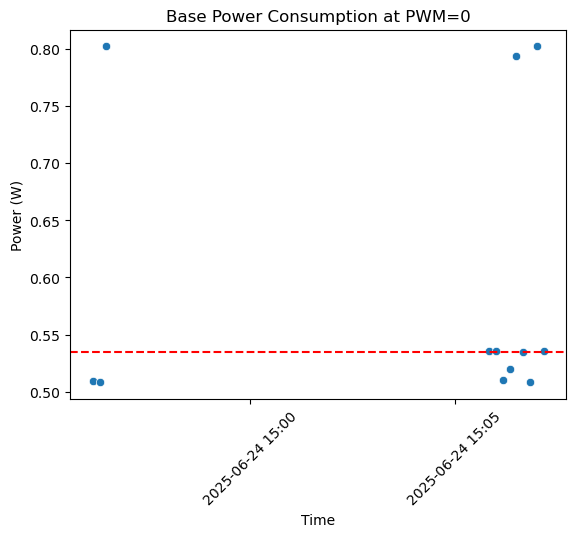

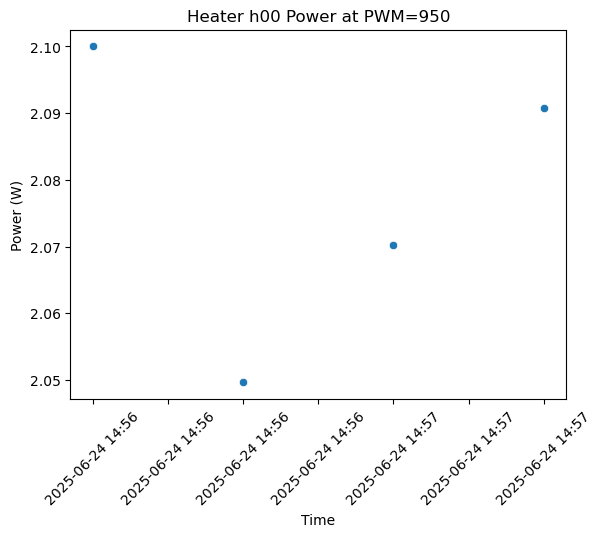

In [23]:
first_dt = pd.Timestamp("2023-10-01T00:00:00Z")
last_dt = pd.Timestamp.now(tz=pd.Timestamp.utcnow().tz)
res = 10 # resolution in seconds.
bucket = "abc_testing"

mcu_uuid = getUUIDFromBoardID(board_id)
if mcu_uuid is None:
    raise ValueError(f"Board ID {board_id} not found in the database.")

filters = {
    "measurement": ["pwr", "htr"],
    "mcu_uuid": mcu_uuid
}

data = download_data_DB(bucket, first_dt, last_dt, res, filters)
print(f"Found {len(data)} entries between {first_dt} and {last_dt} for board ID {board_id}.")

base_power = frameBasePower(data)
print(f"Base power consumption: {base_power} W")

max_htr_powers = findMaxHtrPowers(data, base_power)
print(f"Max heater powers (W) for {board_id}:")
print(max_htr_powers)

# Save the pd.Series as a new line to a CSV file
csv_file = "max_pwm_powers.csv"
df = max_htr_powers.to_frame().T
df.insert(0, "board_id", board_id)
df.loc[0, "base"] = base_power

# If file does not exist, create it and write header
try:
    with open(csv_file, 'x') as f:
        df.to_csv(f, index=False)
except FileExistsError:
    # If file exists, append without writing the header
    with open(csv_file, 'a') as f:
        # If a line starts with the same board_id, we want to update it instead of appending.
        existing_df = pd.read_csv(csv_file)
        if not ((existing_df['board_id'] == board_id).any()):
            df.to_csv(f, index=False, header=False)
        else:
            # If the board_id exists, update the existing row
            existing_df.loc[existing_df['board_id'] == board_id, df.columns] = df.values
            # Order based on board_id column
            existing_df = existing_df.sort_values(by='board_id')
            # Rewrite the entire file
            f.seek(0)
            f.truncate()
            existing_df.to_csv(f, index=False)
